In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import scipy.stats as stats
from time import perf_counter


### Import data

In [411]:
originalDataX = pd.read_csv('data/Data_X.csv')
originalDataY = pd.read_csv('data/Data_Y.csv')
originalDataNew = pd.read_csv('data/DataNew_X.csv')

In [412]:
# Merge X and Y

df = pd.merge(originalDataX, originalDataY, on='ID')


### Data Preparation


In [413]:
# Remove unnecessary columns

df = df.drop(['ID'], axis=1)

In [414]:
# Print and Remove duplicated values

print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


0


In [415]:
# Delete null and missing values
print("Before: ", df.isnull().sum().sum())
df = df.dropna()
print("After: ", df.isnull().sum().sum())


Before:  1002
After:  0


In [416]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


print(df.head())

   DAY_ID  COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
1     501        1       -0.022399       -1.003452       -0.022063  \
2     687        1        1.395035        1.978665        1.021305   
3     720        0       -0.983324       -0.849198       -0.839586   
5     467        1       -0.295296       -0.765120       -0.717490   
6     144        1       -0.234965       -0.677085        0.399588   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT   
1        0.022063      -0.573520      -1.130838       0.573520       1.130838  \
2       -1.021305      -0.622021      -1.682587       0.622021       1.682587   
3        0.839586      -0.270870       0.563230       0.270870      -0.563230   
5        0.717490      -1.117139      -0.200305       1.117139       0.200305   
6       -0.399588       0.183998      -0.986235      -0.183998       0.986235   

   ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP   FR_TEMP   GAS_RET   
1  ... -1.24

In [417]:
# Scale data
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)


# minmax = MinMaxScaler()
# df = pd.DataFrame(minmax.fit_transform(df), columns=df.columns)


### Data Exploration

In [418]:
# Shape
print(df.shape)

(1276, 35)


In [419]:
# List columns
print(df.columns)

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')


In [420]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DAY_ID            1276 non-null   float64
 1   COUNTRY           1276 non-null   float64
 2   DE_CONSUMPTION    1276 non-null   float64
 3   FR_CONSUMPTION    1276 non-null   float64
 4   DE_FR_EXCHANGE    1276 non-null   float64
 5   FR_DE_EXCHANGE    1276 non-null   float64
 6   DE_NET_EXPORT     1276 non-null   float64
 7   FR_NET_EXPORT     1276 non-null   float64
 8   DE_NET_IMPORT     1276 non-null   float64
 9   FR_NET_IMPORT     1276 non-null   float64
 10  DE_GAS            1276 non-null   float64
 11  FR_GAS            1276 non-null   float64
 12  DE_COAL           1276 non-null   float64
 13  FR_COAL           1276 non-null   float64
 14  DE_HYDRO          1276 non-null   float64
 15  FR_HYDRO          1276 non-null   float64
 16  DE_NUCLEAR        1276 non-null   float64


In [421]:
# Describe data
print(df.describe())

             DAY_ID       COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION   
count  1.276000e+03  1.276000e+03    1.276000e+03    1.276000e+03  \
mean  -5.011665e-17  2.784258e-17    2.227407e-17   -8.352775e-18   
std    1.000392e+00  1.000392e+00    1.000392e+00    1.000392e+00   
min   -1.716719e+00 -1.068148e+00   -3.935100e+00   -1.563610e+00   
25%   -8.662014e-01 -1.068148e+00   -6.523718e-01   -7.260343e-01   
50%   -6.915172e-03  9.362001e-01   -1.155892e-01   -4.137645e-01   
75%    8.647927e-01  9.362001e-01    7.563681e-01    6.387449e-01   
max    1.822722e+00  9.362001e-01    2.512826e+00    2.979626e+00   

       DE_FR_EXCHANGE  FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT   
count    1.276000e+03    1.276000e+03    1276.000000   1.276000e+03  \
mean     3.341110e-17   -3.341110e-17       0.000000  -1.670555e-17   
std      1.000392e+00    1.000392e+00       1.000392   1.000392e+00   
min     -2.779043e+00   -2.836752e+00      -2.273731  -2.473398e+00   
25%     -8.426723e-01  

In [422]:
# Variance
print(df.var())

DAY_ID              1.000784
COUNTRY             1.000784
DE_CONSUMPTION      1.000784
FR_CONSUMPTION      1.000784
DE_FR_EXCHANGE      1.000784
FR_DE_EXCHANGE      1.000784
DE_NET_EXPORT       1.000784
FR_NET_EXPORT       1.000784
DE_NET_IMPORT       1.000784
FR_NET_IMPORT       1.000784
DE_GAS              1.000784
FR_GAS              1.000784
DE_COAL             1.000784
FR_COAL             1.000784
DE_HYDRO            1.000784
FR_HYDRO            1.000784
DE_NUCLEAR          1.000784
FR_NUCLEAR          1.000784
DE_SOLAR            1.000784
FR_SOLAR            1.000784
DE_WINDPOW          1.000784
FR_WINDPOW          1.000784
DE_LIGNITE          1.000784
DE_RESIDUAL_LOAD    1.000784
FR_RESIDUAL_LOAD    1.000784
DE_RAIN             1.000784
FR_RAIN             1.000784
DE_WIND             1.000784
FR_WIND             1.000784
DE_TEMP             1.000784
FR_TEMP             1.000784
GAS_RET             1.000784
COAL_RET            1.000784
CARBON_RET          1.000784
TARGET        

In [423]:
# Print target mean by country

print(df.groupby('COUNTRY')['TARGET'].mean())

COUNTRY
-1.068148    0.057226
 0.936200   -0.050157
Name: TARGET, dtype: float64


/var/folders/fw/2h3gl8xx695ctwssxd73bz5c0000gn/T/ipykernel_11718/82092166.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


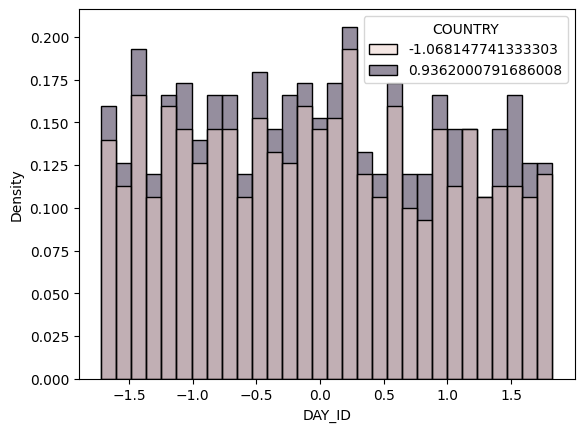

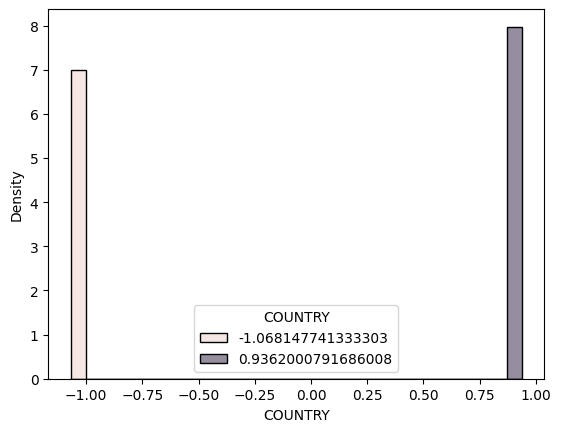

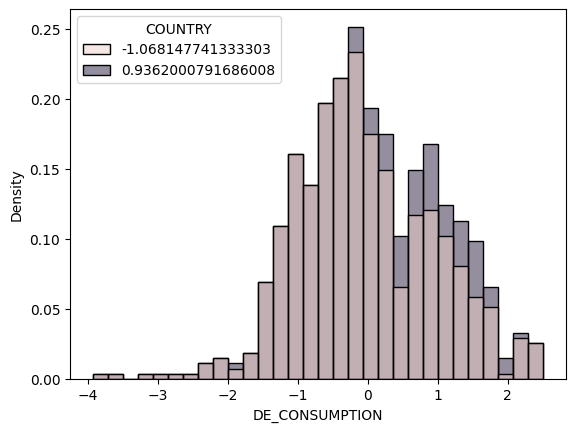

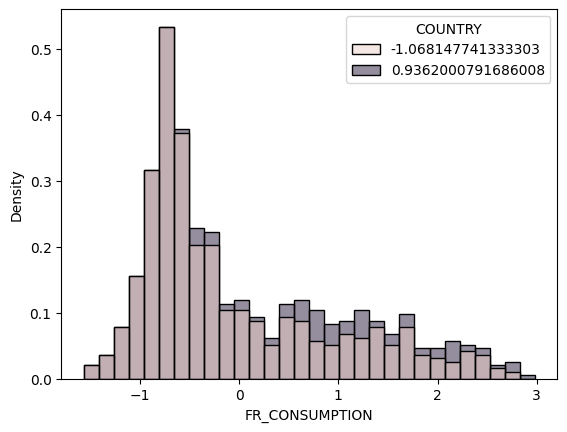

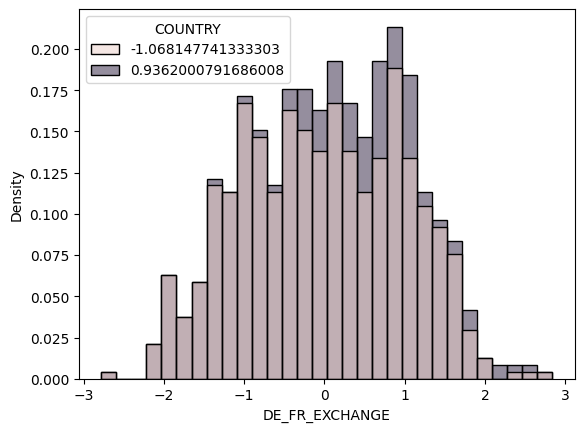

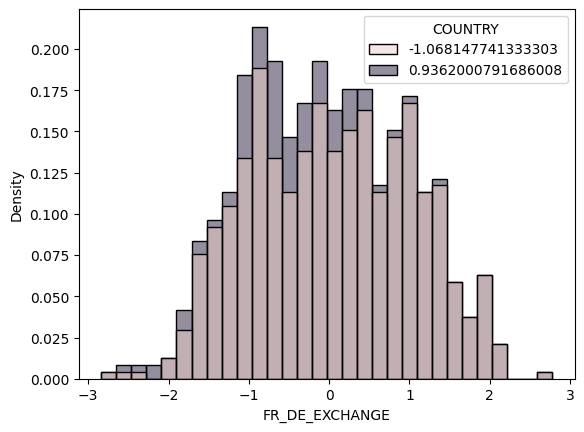

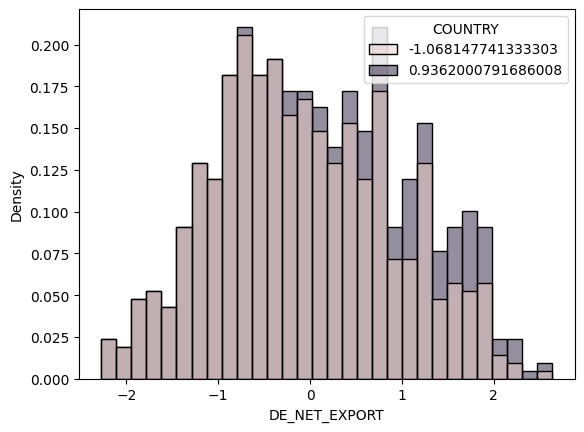

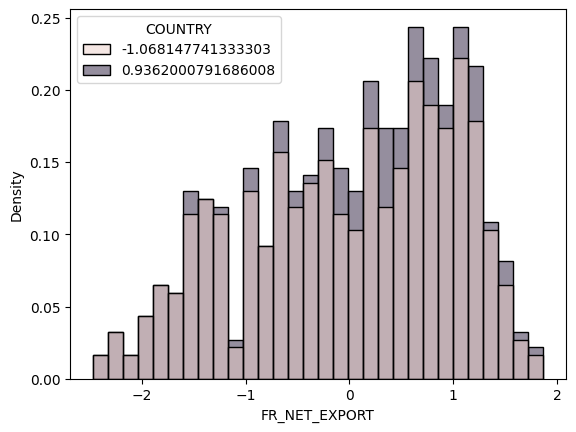

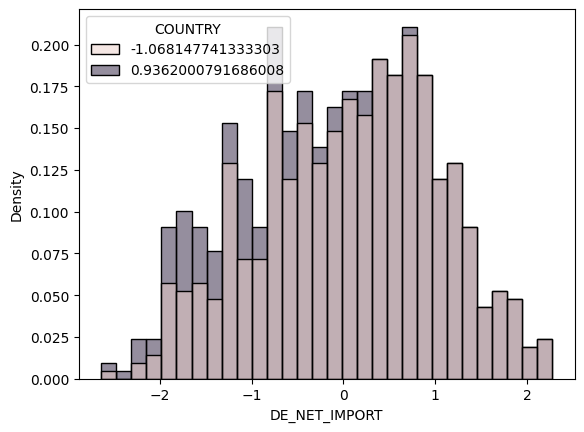

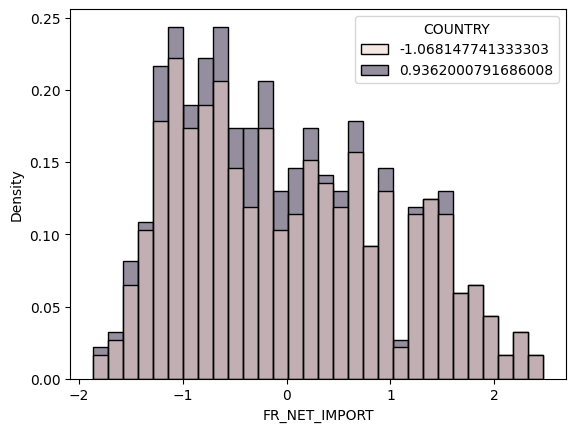

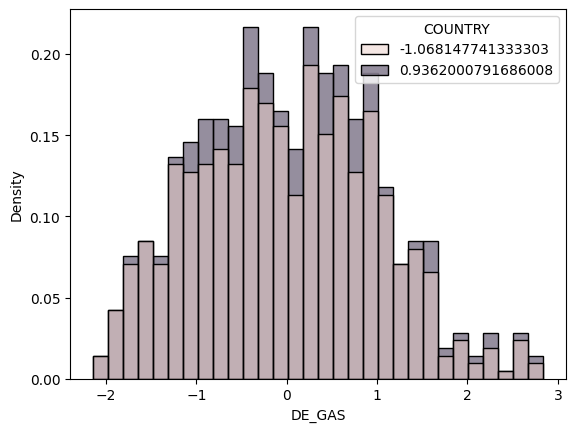

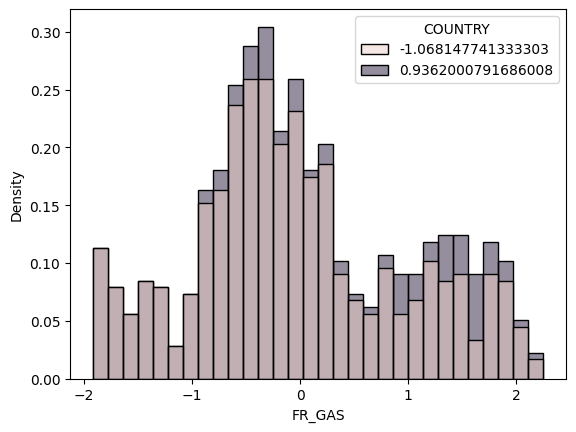

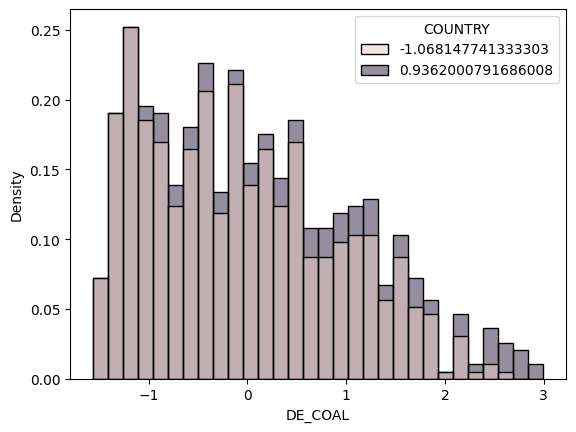

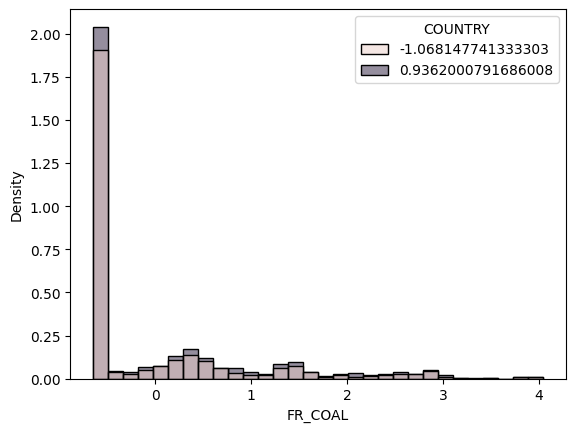

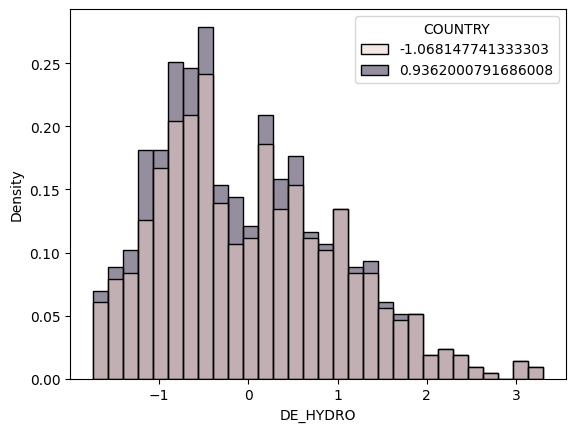

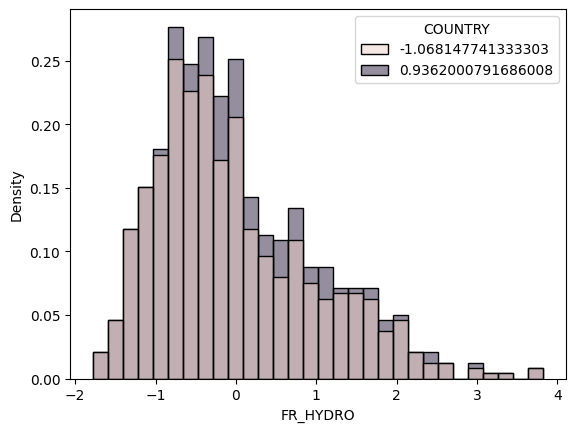

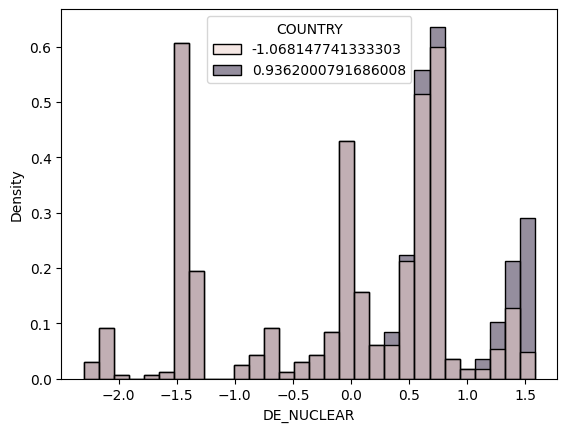

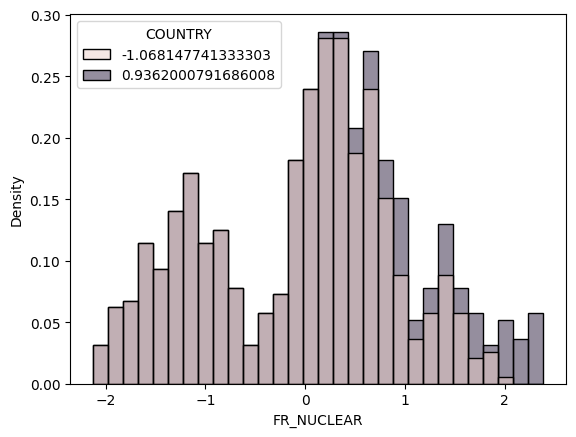

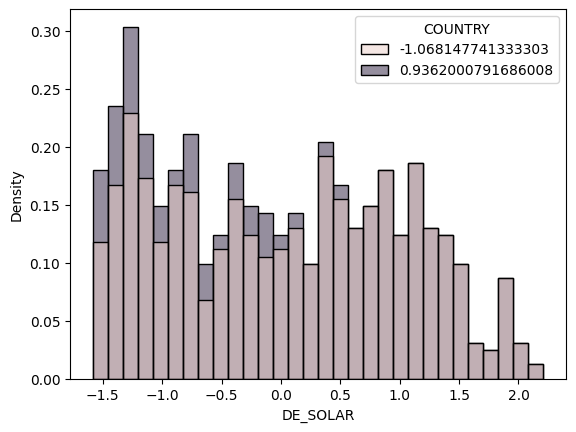

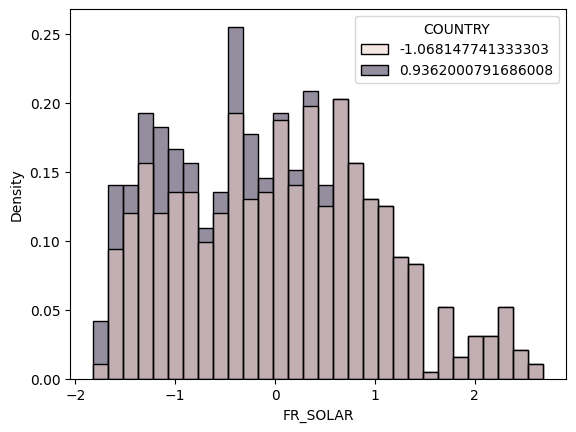

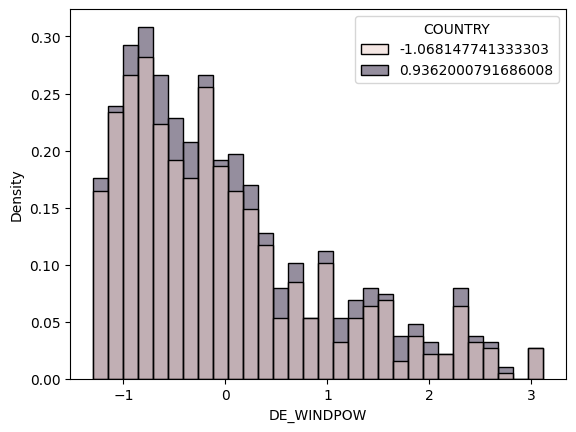

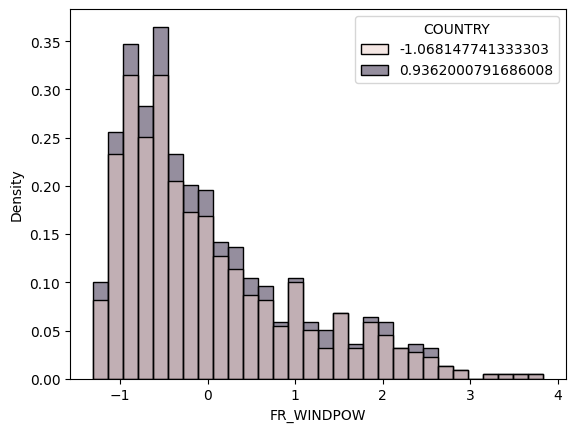

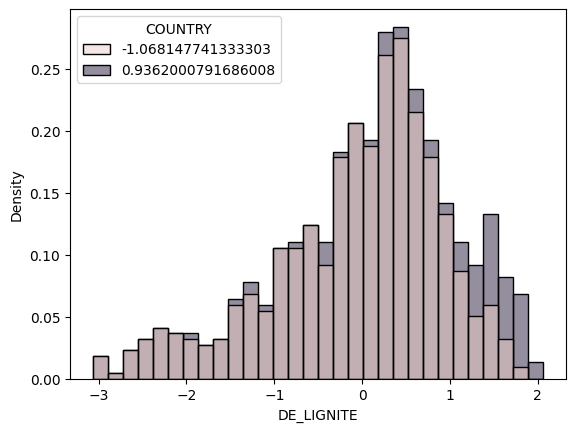

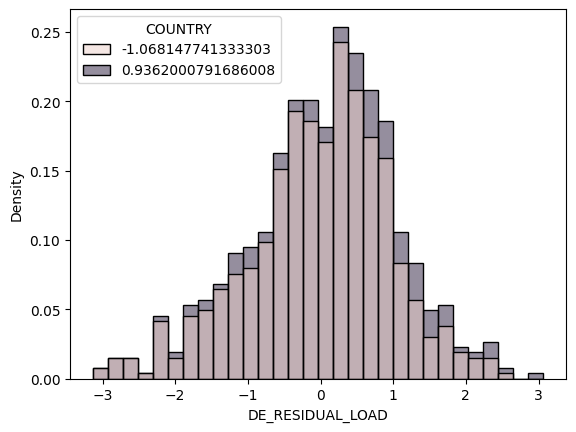

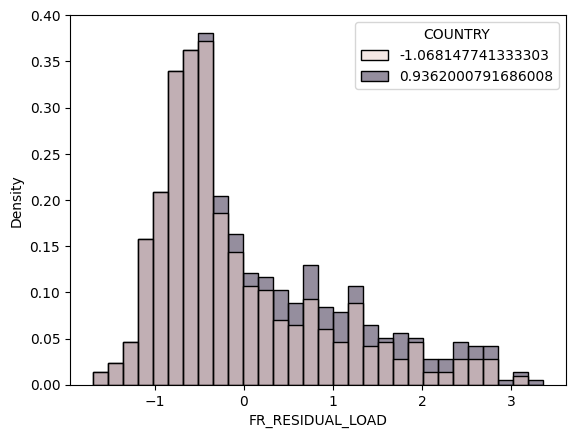

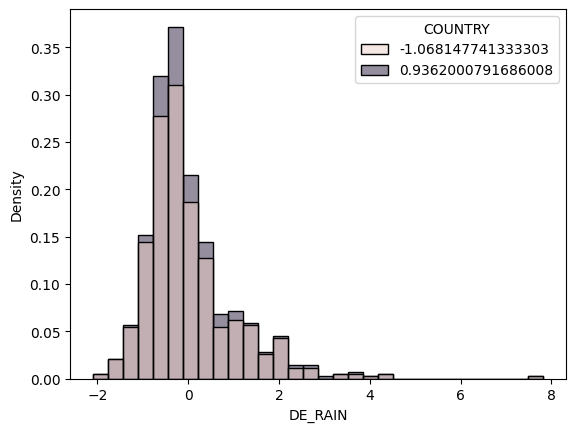

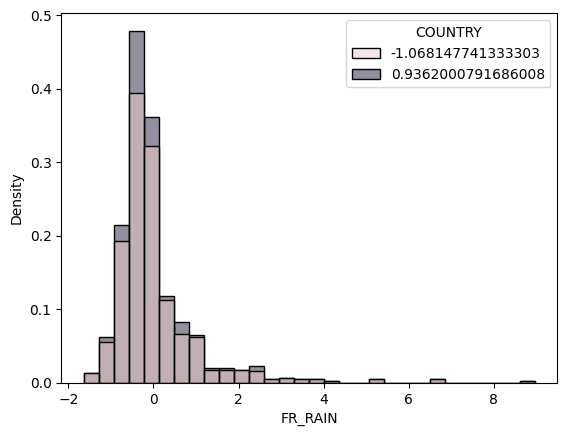

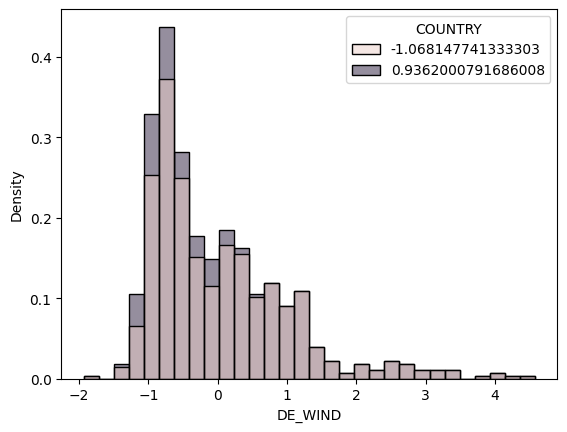

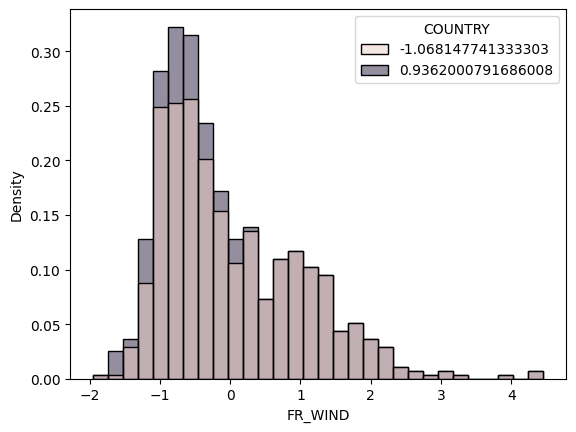

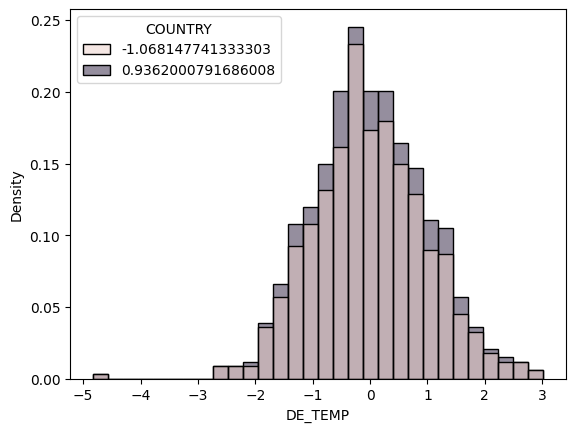

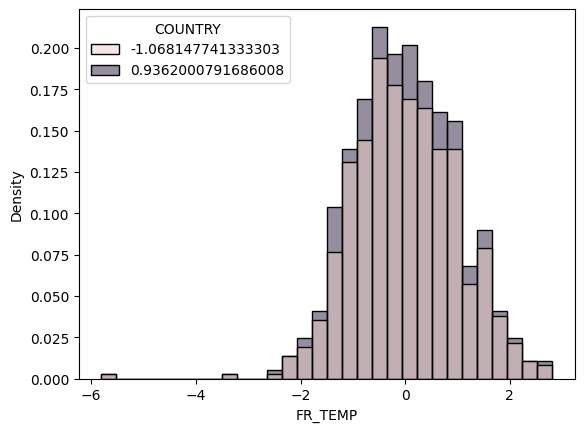

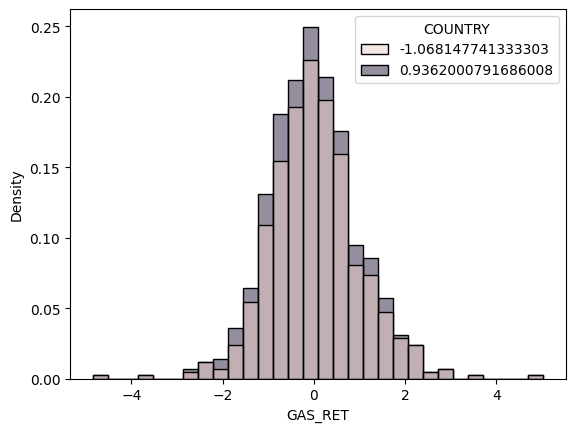

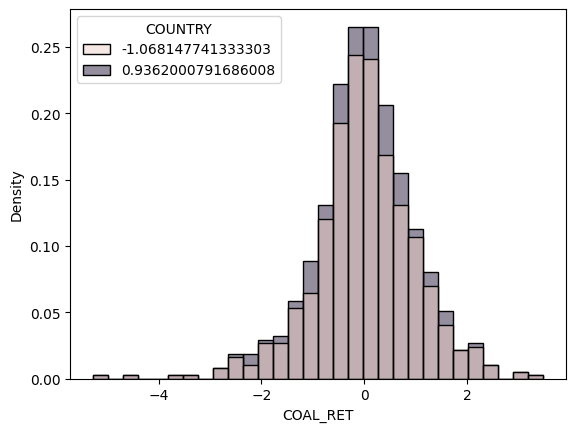

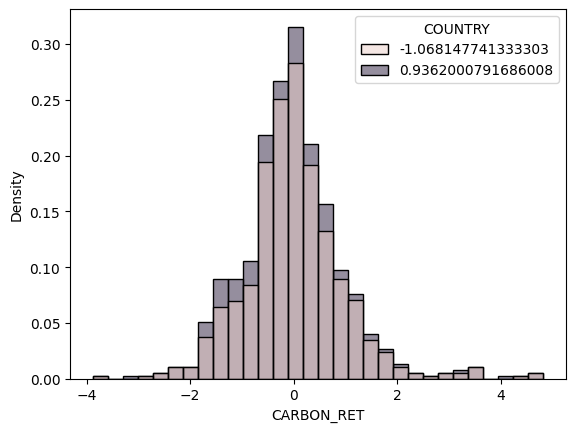

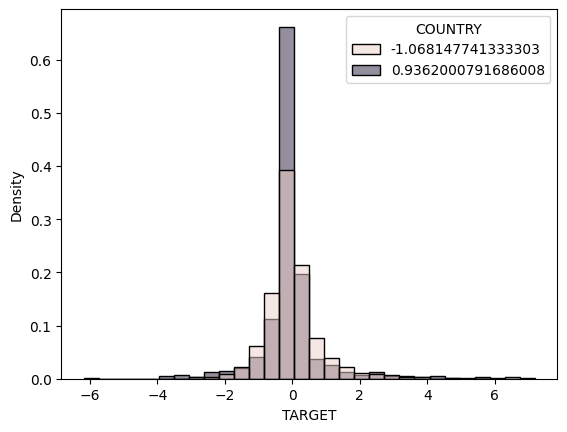

In [424]:
#Plot the density of each columns by country

for col in df.columns:
    plt.figure()
    sns.histplot(x=col, hue='COUNTRY', data=df, bins=30, stat="density")


<Axes: >

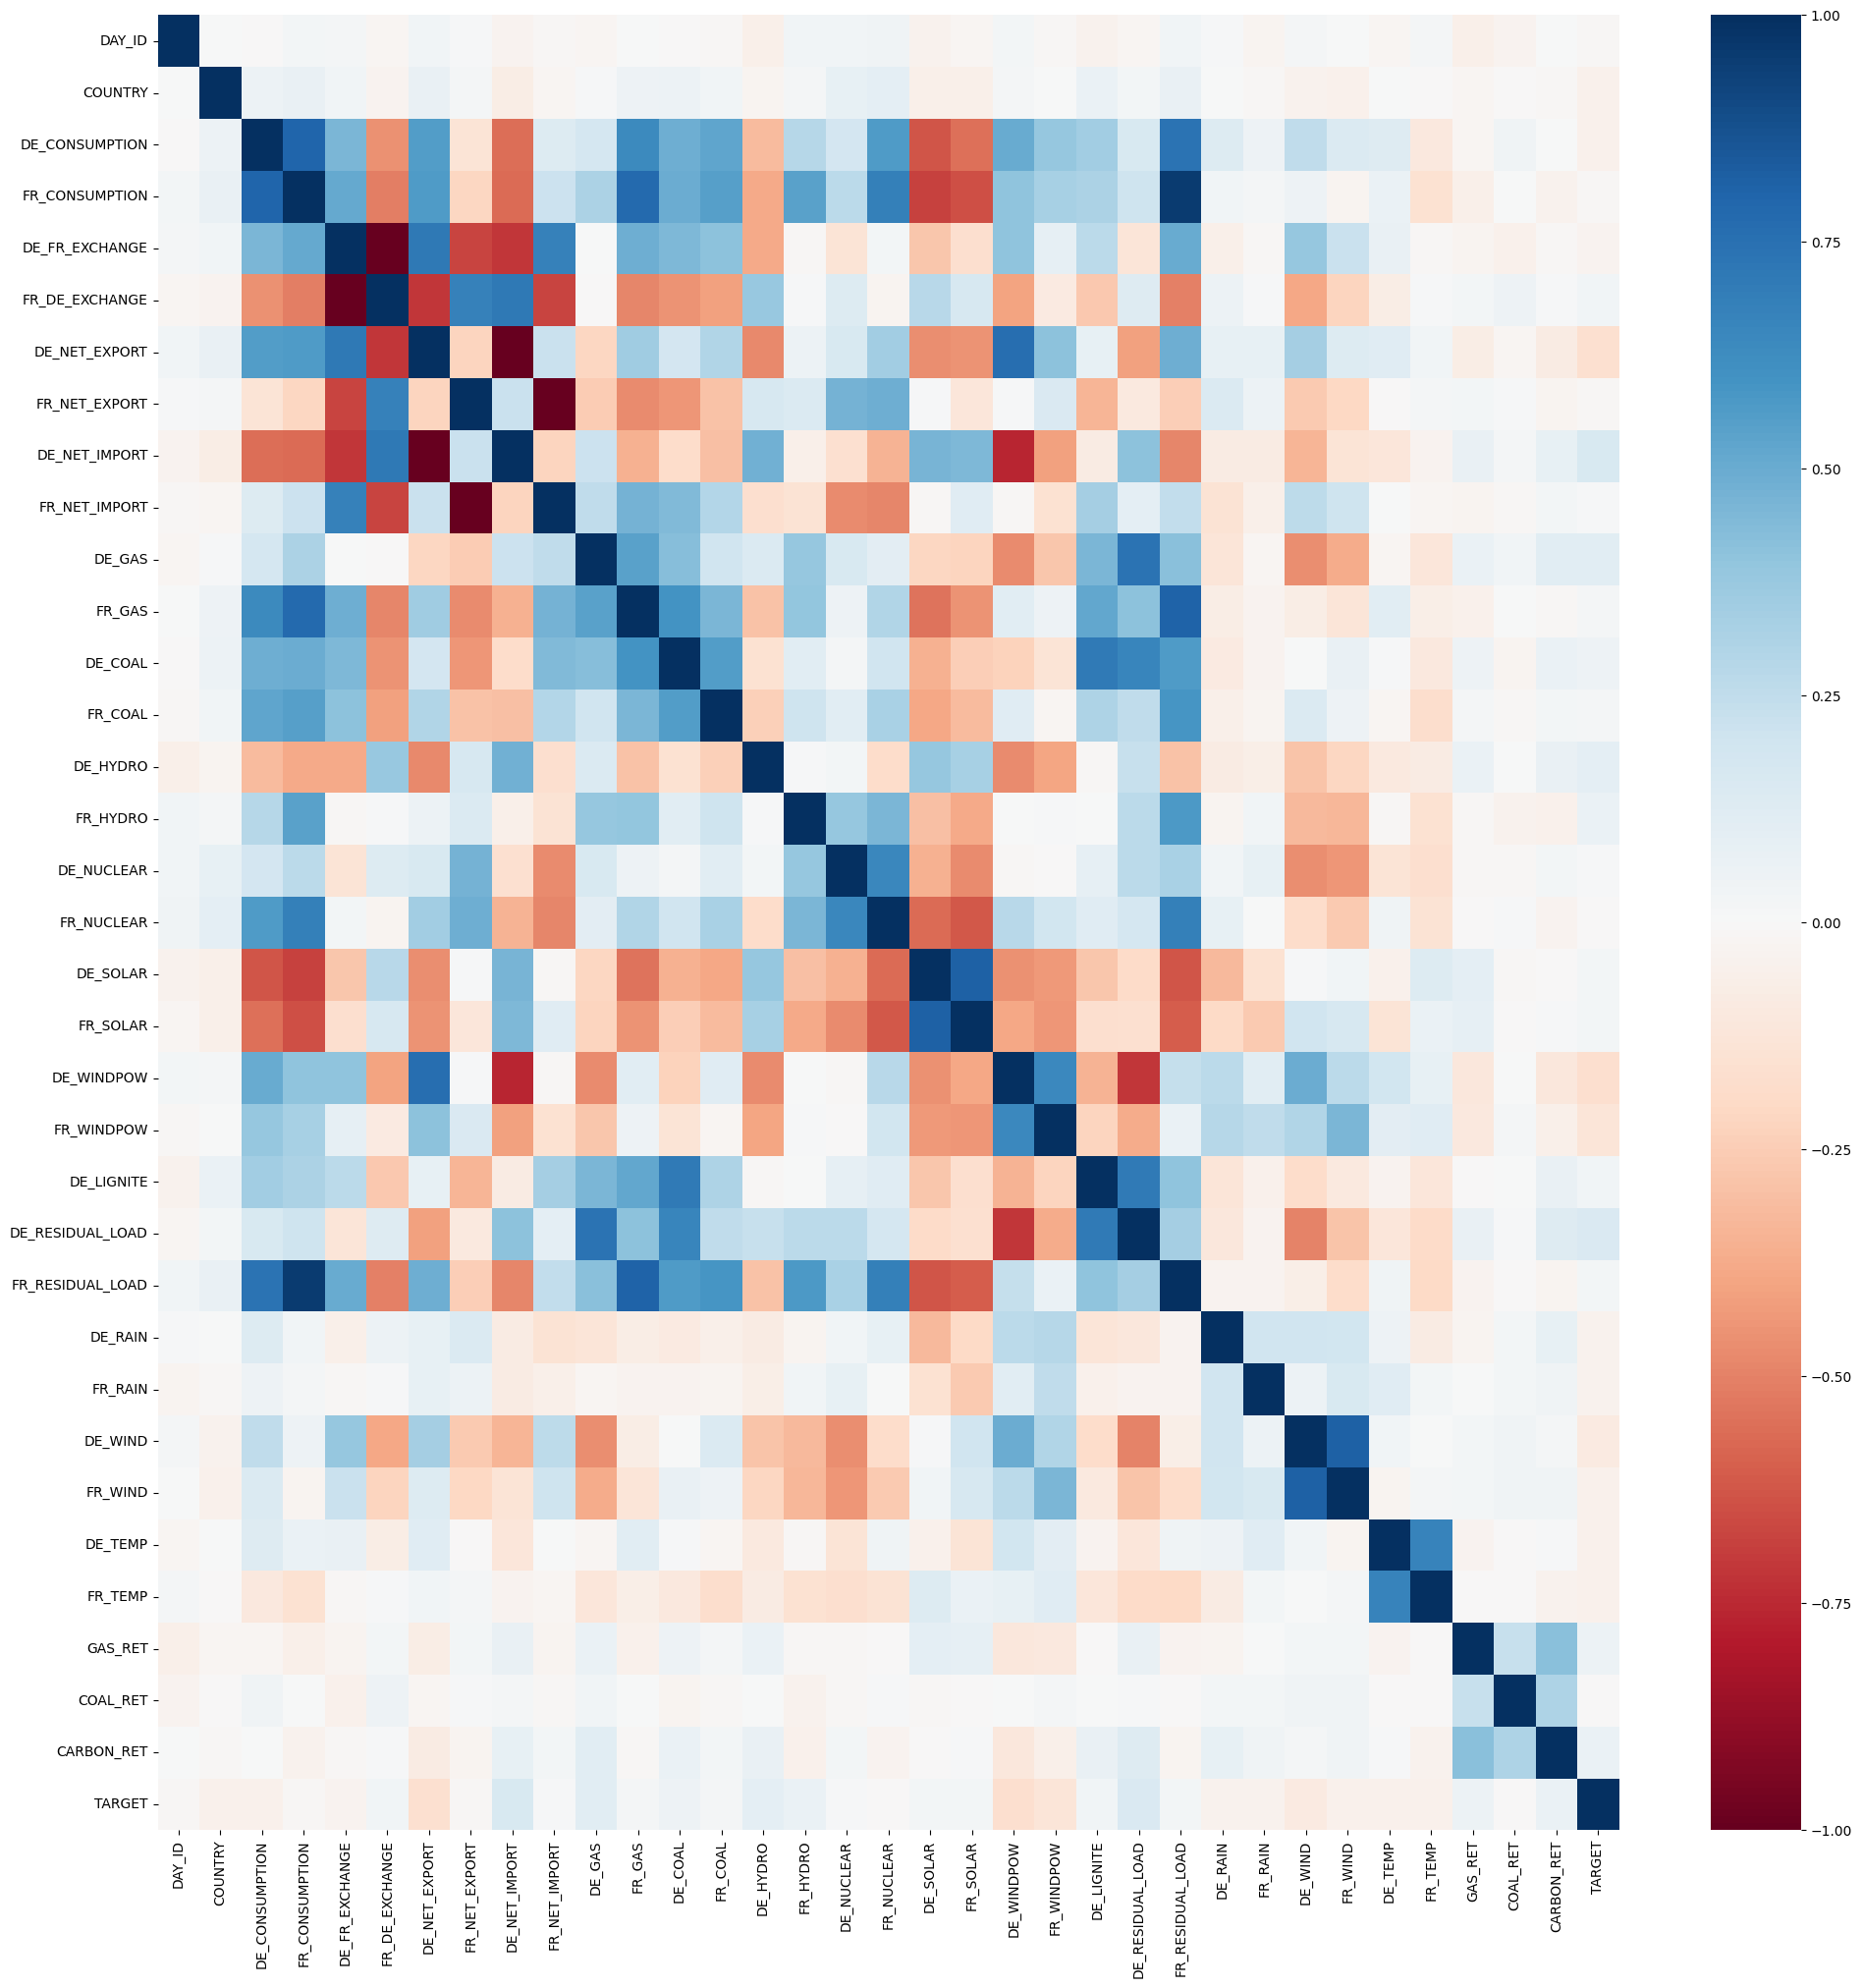

In [425]:
# Plot correlation matrix with heatmap

plt.figure(figsize=(24, 24))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='RdBu')

In [426]:
# Print each column correlation with each other
treashold = 0.7
variable_seen = []
highest_correlation = []
for i in df.columns:
    for j in df.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and (df[i].corr(df[j]) > treashold or df[i].corr(df[j]) < -treashold) and i != 'TARGET' and j != 'TARGET':
                print("{:>20} <---> {:<20} :  {}".format(i, j, df[i].corr(df[j])))
                highest_correlation.append(i)


      DE_CONSUMPTION <---> FR_CONSUMPTION       :  0.8000247966026744
      DE_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.735505472780259
      FR_CONSUMPTION <---> FR_GAS               :  0.7810476807964117
      FR_CONSUMPTION <---> FR_RESIDUAL_LOAD     :  0.9608380589254399
      DE_FR_EXCHANGE <---> FR_DE_EXCHANGE       :  -0.9999999999999998
      DE_FR_EXCHANGE <---> DE_NET_EXPORT        :  0.7117079572436998
      DE_FR_EXCHANGE <---> DE_NET_IMPORT        :  -0.7117079572436998
      FR_DE_EXCHANGE <---> DE_NET_EXPORT        :  -0.7117079572436998
      FR_DE_EXCHANGE <---> DE_NET_IMPORT        :  0.7117079572436998
       DE_NET_EXPORT <---> DE_NET_IMPORT        :  -0.9999999999999998
       DE_NET_EXPORT <---> DE_WINDPOW           :  0.7611406500398217
       FR_NET_EXPORT <---> FR_NET_IMPORT        :  -1.0
       DE_NET_IMPORT <---> DE_WINDPOW           :  -0.7611406500398217
              DE_GAS <---> DE_RESIDUAL_LOAD     :  0.7390286231083029
              FR_GAS <---> FR_

##### Interpretation of correlations

What we can deduce is that the french and german's consumption is extremely linked, with a correlation of 80%.
We can also see that the french consumption is linked to the gas consumption at 78%, so french electricity depends on gas a lot.
The more the french consumption augments, the more they use the residual load, because there aren't enough renewable energies. We can also see that the residual load is mostly constitued by gas.
Germans export a lot of wind energy.

When french's solar energy is high, the german's solar energy is high too, most likely because the two countries are close and subject to the same weather conditions.

In [427]:
# Delete columns with high correlation

df = df.drop(highest_correlation, axis=1)

TARGET              1.000000
DE_RESIDUAL_LOAD    0.153695
FR_WINDPOW          0.131933
DE_HYDRO            0.095676
CARBON_RET          0.066687
FR_HYDRO            0.062634
GAS_RET             0.058030
FR_WIND             0.053708
COUNTRY             0.053575
DE_TEMP             0.053219
FR_TEMP             0.052706
DE_RAIN             0.045790
FR_RAIN             0.044499
FR_SOLAR            0.026524
FR_RESIDUAL_LOAD    0.025200
FR_COAL             0.017407
DE_NUCLEAR          0.014791
FR_NET_IMPORT       0.014082
DAY_ID              0.012872
COAL_RET            0.002627
FR_NUCLEAR          0.001259
Name: TARGET, dtype: float64


<Axes: >

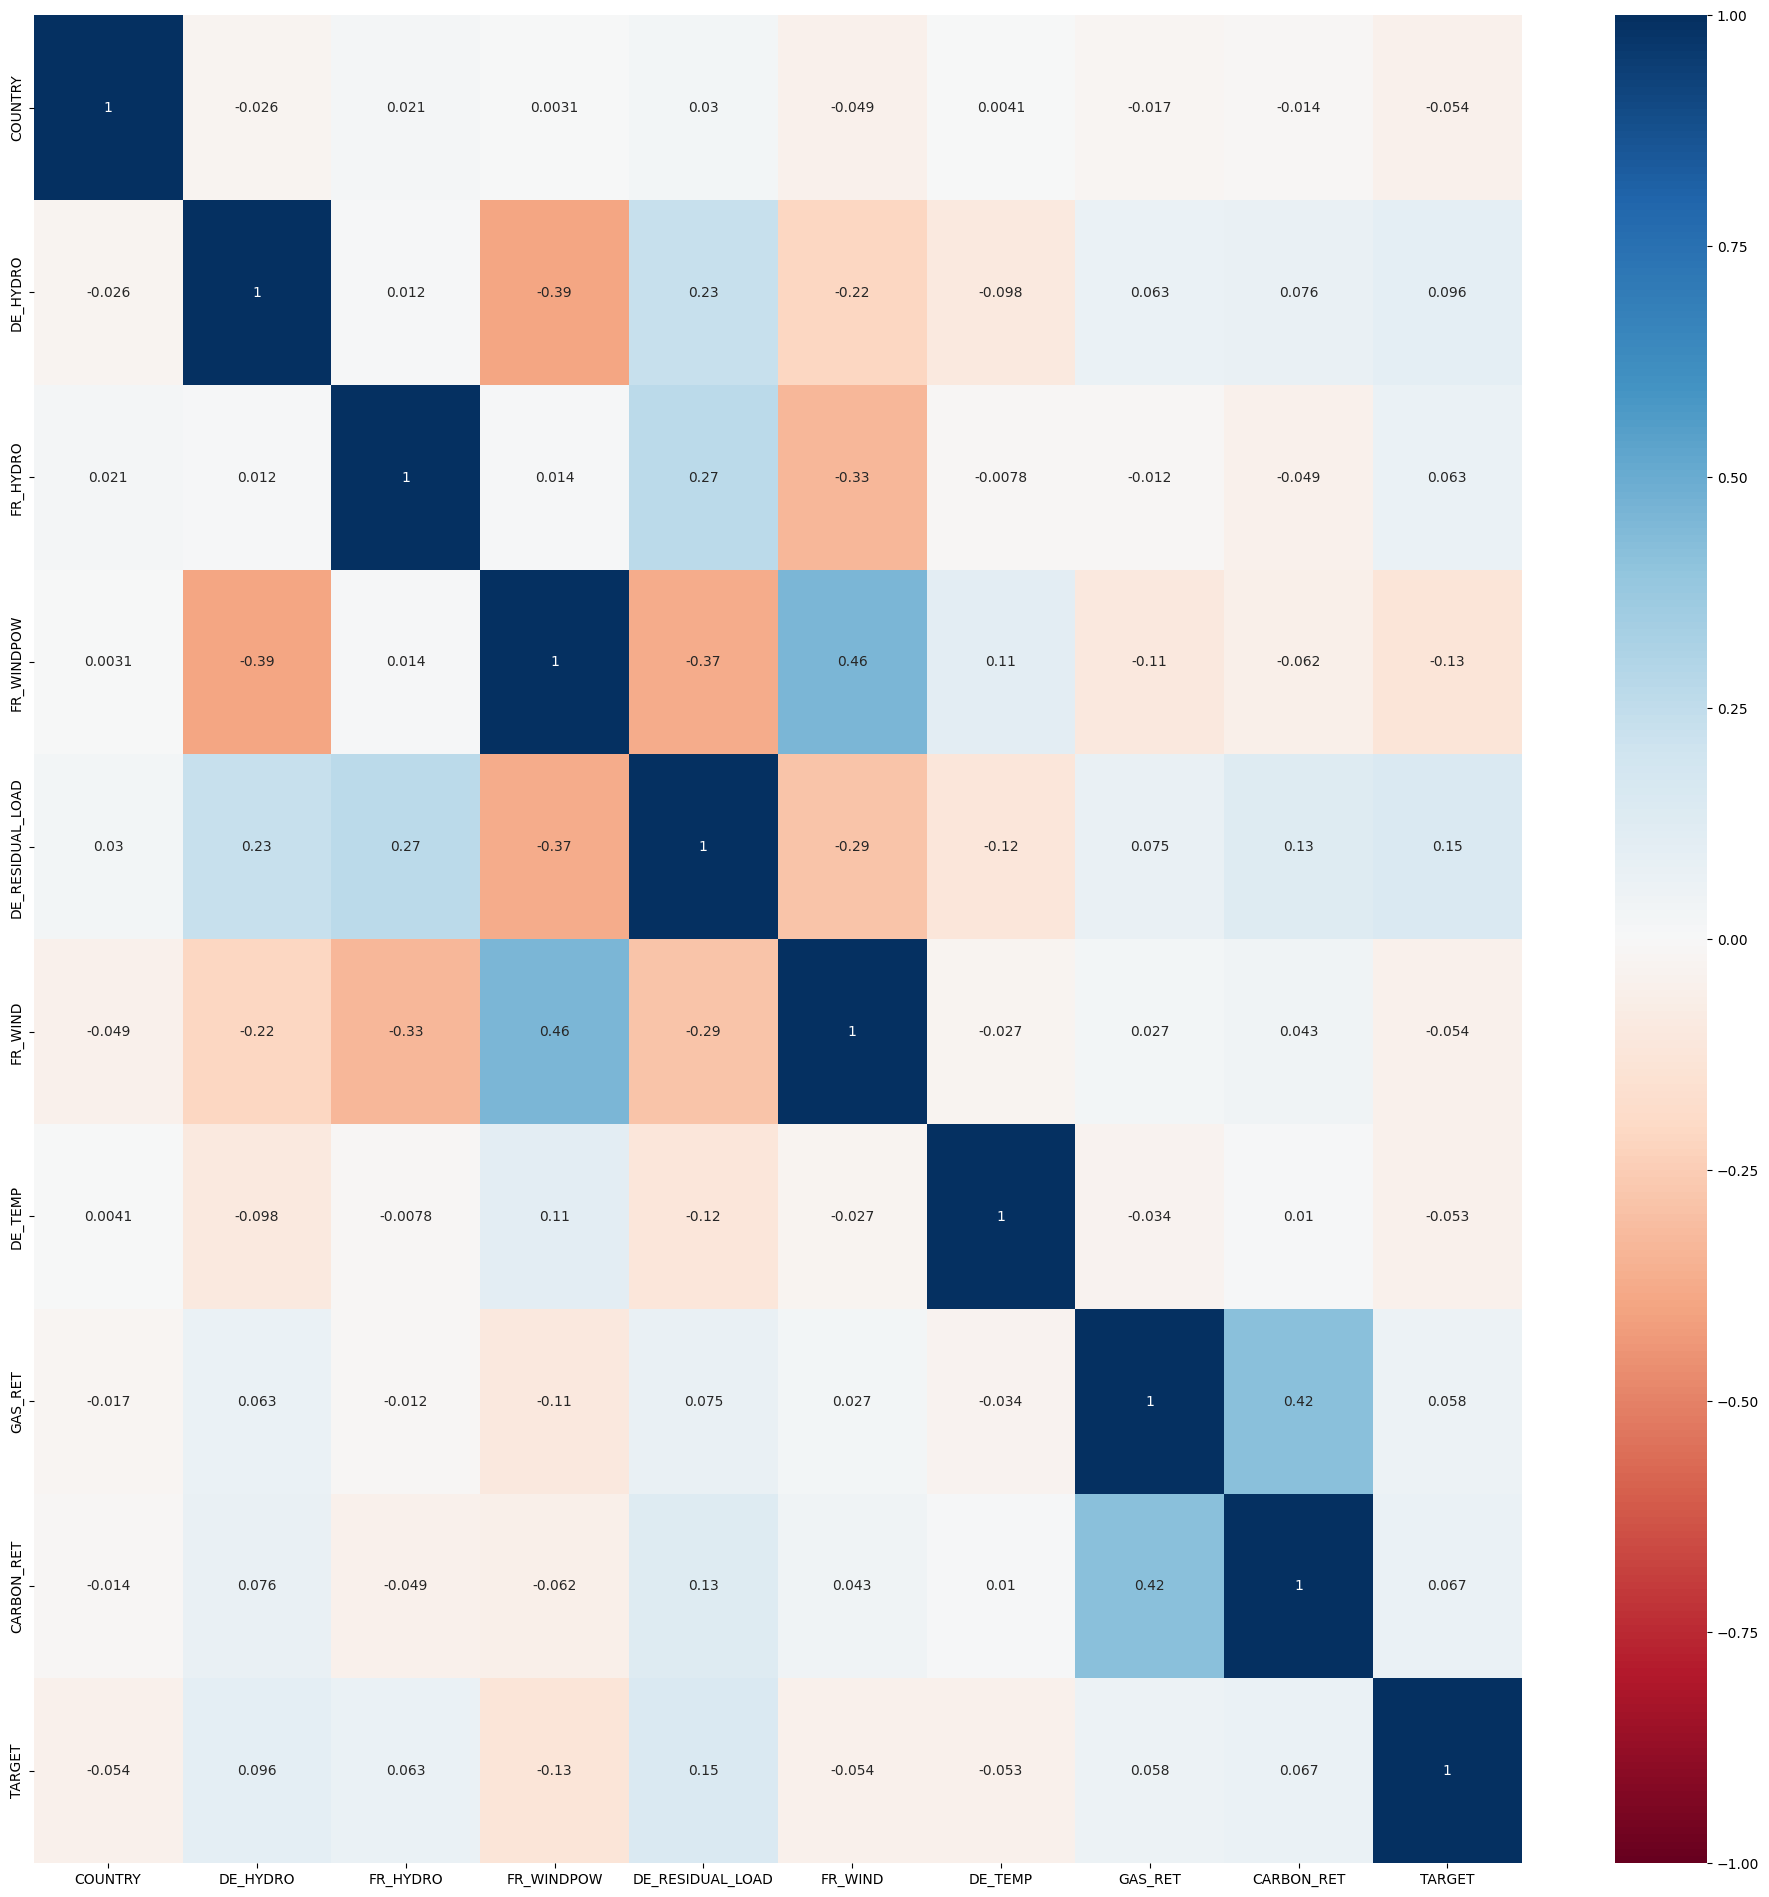

In [428]:
# Keep 5 most correlated columns with target column and delete the others

corr_target = abs(df.corr()['TARGET'])

print(corr_target.sort_values(ascending=False))

df = df.drop(corr_target.sort_values(ascending=False)[10:].index, axis=1)

# Print the 5 most correlated columns with target column

plt.figure(figsize=(24, 24))
sns.heatmap(df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)


### Data Analysis

In [429]:
# Fit a model and plot the evolution of the train and test scores with the hyperparameter

def fit_and_vary_hyperparameters(regressor, param_grid, X, y):
    grid = GridSearchCV(estimator=regressor, 
                        param_grid=param_grid, 
                        cv=KFold(n_splits=5, 
                                shuffle=True, 
                                random_state=int(perf_counter ()*100)
                                ),     
                        scoring=['neg_mean_squared_error', 'r2'], 
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True,
                        refit='neg_mean_squared_error'
                        )
    
    grid.fit(X, y)

    print("Best score: {}".format(-grid.best_score_))
    print("Best r2 score: {}".format(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    print("Best parameters: {}".format(grid.best_params_))
  

    # Plot the evolution of the train and test scores with the hyperparameter for each metric with the best parameters

    data = pd.DataFrame(grid.cv_results_)
    
    for param in param_grid:
        data_to_plot = data.copy()

        # Go through each hyperparameter and delete all the line where the other parameter are not the best

        for other_param in param_grid:
            if other_param != param:
                data_to_plot = data_to_plot[data_to_plot['param_' + other_param] == grid.best_params_[other_param]]

        # Check if the hyperparameter is a list of numbers or a list of strings
        if type(param_grid[param][0]) == int or float or np.float64:
            param_to_plot = param_grid[param]
        else:
            print(type(param_grid[param][0]))
            param_to_plot = [str(i) for i in param_grid[param]]

        plt.figure(figsize=(12,4))
        plt.plot(param_to_plot, -data_to_plot['mean_train_neg_mean_squared_error'], label='Train')
        plt.plot(param_to_plot, -data_to_plot['mean_test_neg_mean_squared_error'], label='Test')
        plt.xlabel(param)
        plt.ylabel('mean_squared_error')
        plt.legend()
        plt.show()

    return grid

  

   



  
        
    


    

In [430]:
# Split data

X = df.copy().drop(['TARGET'], axis=1)
y = df['TARGET']

models = {}

##### Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: 0.9781730892705855
Best r2 score: 0.018495444210114332
Best parameters: {'fit_intercept': False}


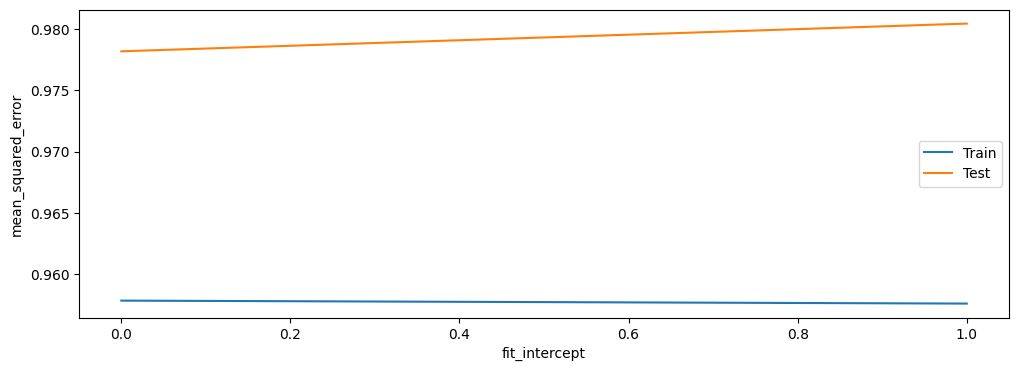

In [431]:
# Linear regression

models["linear_regression"]= fit_and_vary_hyperparameters(LinearRegression(), {'fit_intercept': [True, False]}, X, y)


##### Regularized Linear Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.9762259169515556
Best r2 score: 0.023449268913703736
Best parameters: {'alpha': 517.9474679231203}


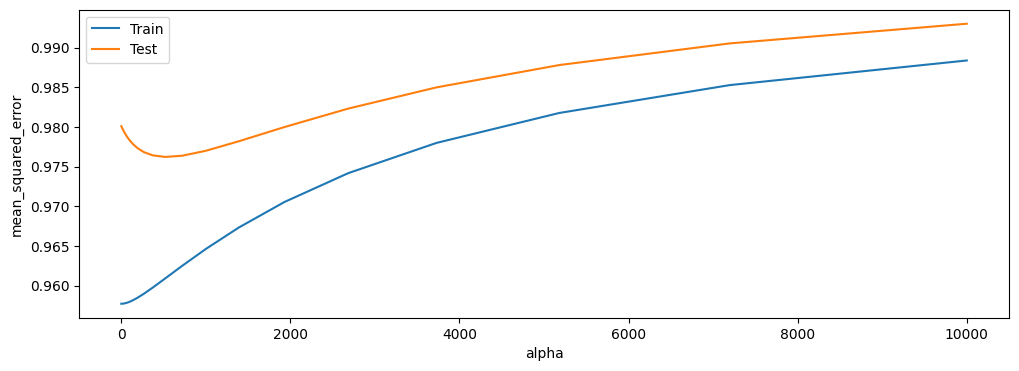

In [432]:
# RIDGE Regression
hyperparameters = {
    'alpha': np.logspace(-3, 4),
}

models["ridge"] = fit_and_vary_hyperparameters(Ridge(), hyperparameters, X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.984817729971154
Best r2 score: 0.01213510081106326
Best parameters: {'alpha': 0.012648552168552958}


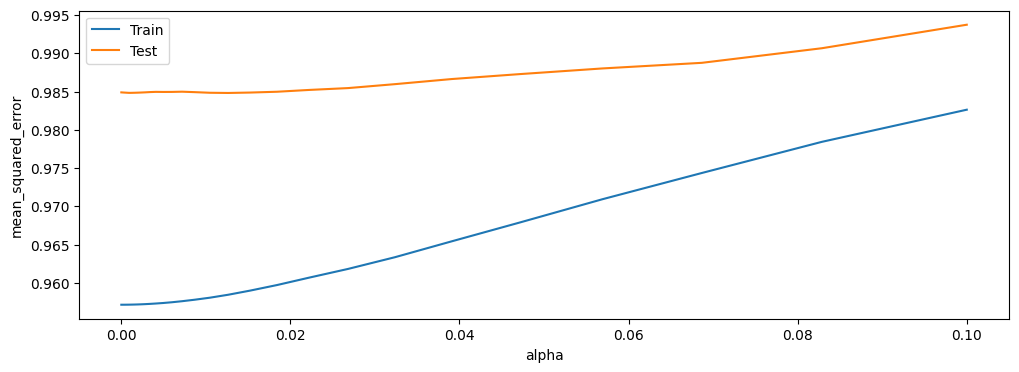

In [433]:
# Lasso Regression
hyperparameters = {
    'alpha': np.logspace(-5, -1),
}

models["lasso"] = fit_and_vary_hyperparameters(Lasso(), hyperparameters, X, y)

##### K-Nearest Neighbors

Fitting 5 folds for each of 58 candidates, totalling 290 fits
Best score: 0.9681874014932447
Best r2 score: 0.02908859952908429
Best parameters: {'n_neighbors': 65}


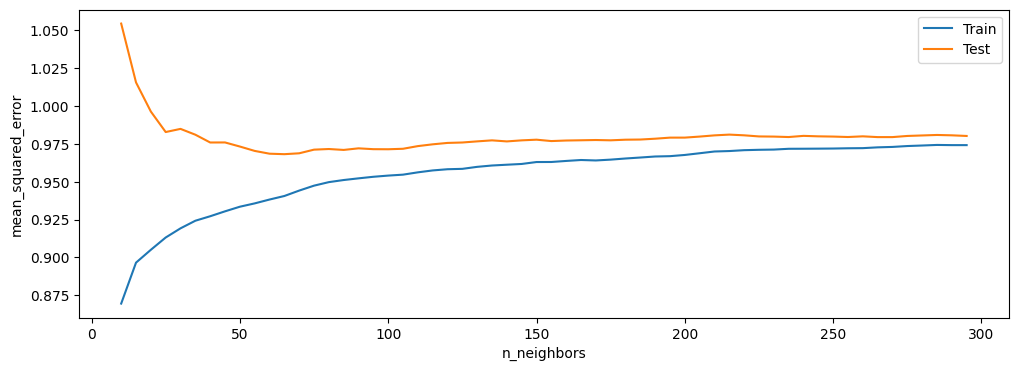

In [434]:
# KNN Regression
hyperparameters = {
    'n_neighbors': range(10, 300, 5),
}

models["knn"] = fit_and_vary_hyperparameters(KNeighborsRegressor(), hyperparameters, X, y)
 

##### Decision Tree

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.9806964905973468
Best r2 score: 0.017249792844007007
Best parameters: {'max_depth': 1}


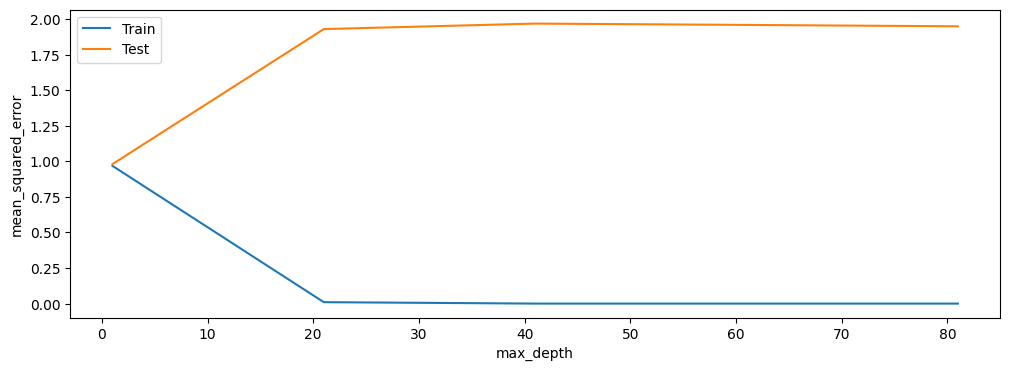

In [435]:
# Decision Tree Regression with different depth

hyperparameters = {
    'max_depth': range(1, 100, 20),
}

models["decision_tree"] = fit_and_vary_hyperparameters(DecisionTreeRegressor(), hyperparameters, X, y)

##### Random Forest

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best score: 0.9844728754956036
Best r2 score: 0.007278739441041559
Best parameters: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 50}


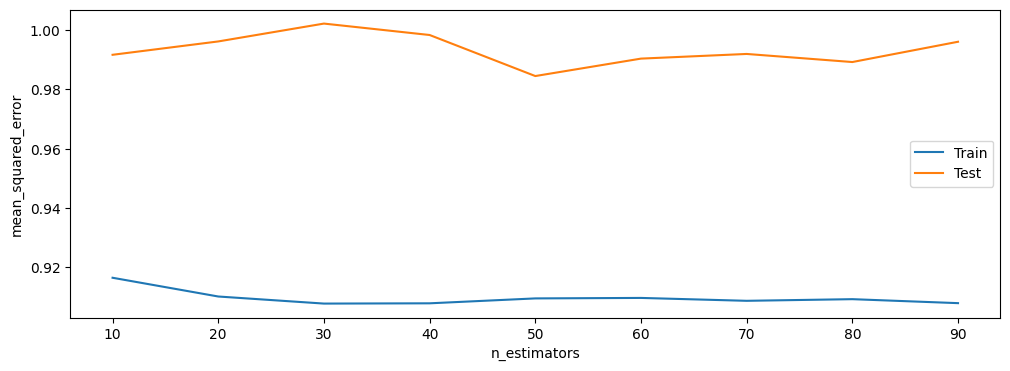

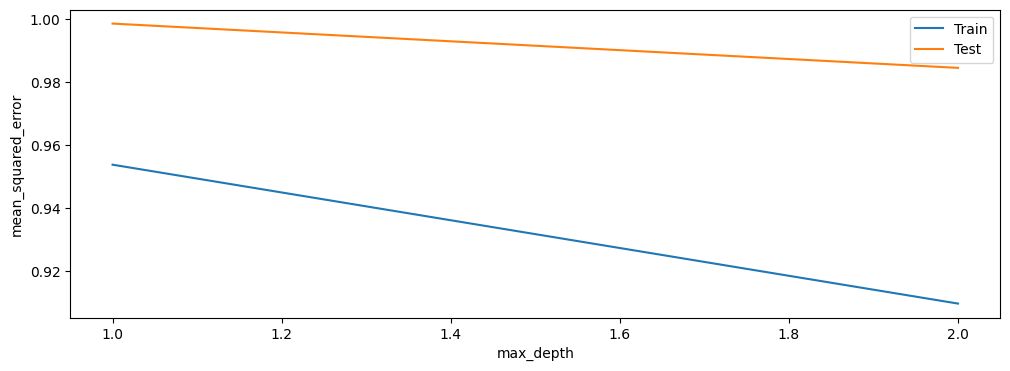

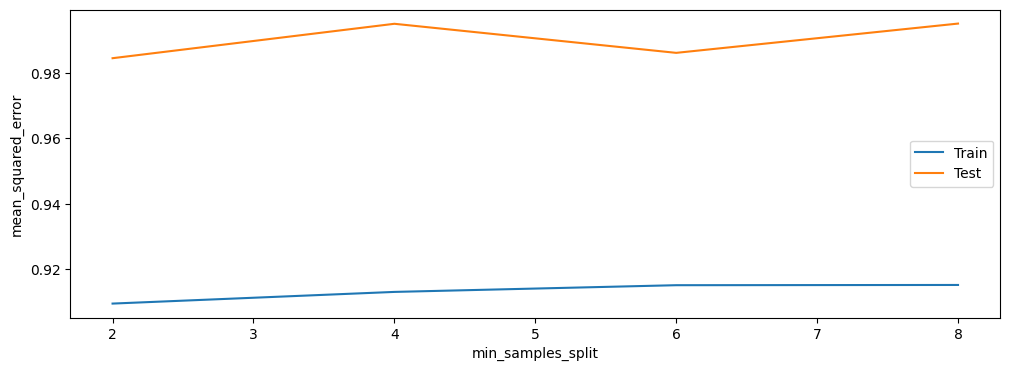

In [436]:
# Random Forest Regression

hyperparameters = {
    'n_estimators': range(10, 100, 10),
    'max_depth': [1, 2],
    'min_samples_split': range(2, 10, 2),
}

models["random_forest"] = fit_and_vary_hyperparameters(RandomForestRegressor(), hyperparameters, X, y)

##### Neural Network

In [437]:
# Neural Network Regression with cross validation

# hyperparameters = {
#     'hidden_layer_sizes': [(100), (100, 100)],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
# }

# models["neural_network"] = fit_and_vary_hyperparameters(MLPRegressor(max_iter=2000), hyperparameters, X, y)


### Ranking of the models

<Axes: >

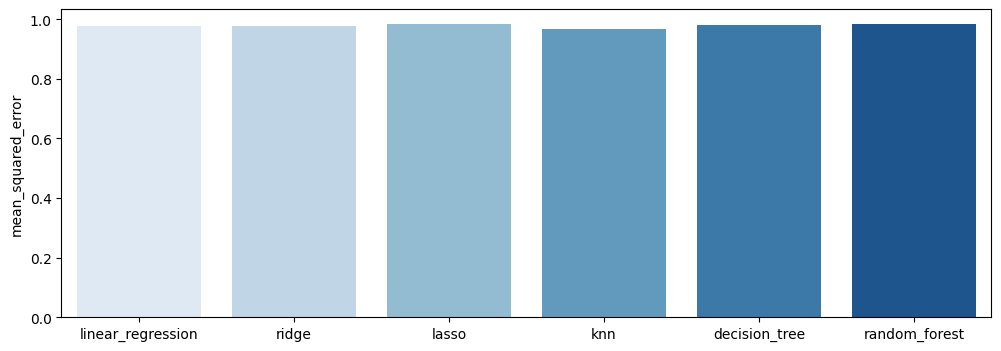

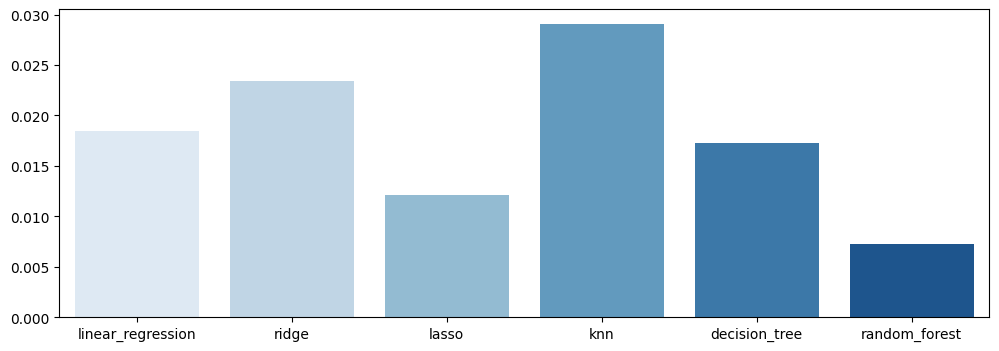

In [438]:
# Plot each model r2 and mean error in a bar plot with sns

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[-models[model].best_score_ for model in models], palette='Blues')
plt.ylabel('mean_squared_error')

plt.figure(figsize=(12, 4))
sns.barplot(x=list(models.keys()), y=[models[model].cv_results_['mean_test_r2'][models[model].best_index_] for model in models], palette='Blues')


    